In [1]:
#Bibliotecas
import numpy as np
import pandas as pd
import networkx as nx
import pylab as plt
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.algorithms.bipartite.generators import complete_bipartite_graph
#Biblioteca para tratar intercalação e permutação, além da escolha aleatória
import itertools
from collections import defaultdict
from networkx.utils import arbitrary_element
import re
import unicodedata
from unicodedata import normalize
from fuzzywuzzy import fuzz, process
import community
import community as community_louvain
import seaborn as sns
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

Alunos: Eduardo, Vitor, Daniel e Ricardo.

MIA: Análise de Dados em Grafos - PG-0083-23-X501

In [2]:
#Importando o Dataset
df_dados = pd.read_csv('ppgia_coautoria-bipartite.csv', delimiter=';', error_bad_lines=False, index_col=False, dtype='unicode', encoding='utf-8')

#Definindo a ANO como indice
df_dados.set_index('ANO', inplace=True)

#Ordenação por Autores ascedente
df_dados.sort_values(by=['AUTORES'], inplace=True)

#Criando o relacionamento
#df_dados['RELACAO'] = df_dados['TITULO']+';'+df_dados['AUTORES']

#Reordenando as colunas para uma melhor visualização
#df_dados = df_dados[['AUTORES', 'TITULO']]

#Exibir os dados
df_dados.head(15)

,TITULO,AUTORES
ANO,,
2013,The Crosscutting Impact Of The Aosd Brazilian ...,"""Claudio Sant'Anna"""
2019,Classification Of Eeg Signals To Detect Alcoho...,"""Eug'Nio Peixoto Jr"""
2010,Collective Intelligence In Law Enforcement Â ...,"""Johnatas D'Orleans"""
2009,An Evaluation Of The Performance Impact Of Gen...,"""Jonathan D'Orleans"""
2019,Detecting Parkinson's Disease With Sustained P...,"""Rytis Maskeli'Nas"""
2010,Drilling Tool Geometry Evaluation For Reinforc...,A Aguiar Vieira
2013,Drilling Delamination Outcomes On Glass And Si...,A Aguiar Vieira
2019,Deep Learning Iot System For Online Stroke Det...,A C Da S Barros
2009,Phase Transformations Evaluation On An Uns S31...,A C G Varela


In [3]:
#Descrição Resumida
df_dados.describe()

,TITULO,AUTORES
count,2370,2370
unique,478,984
top,The Crosscutting Impact Of The Aosd Brazilian ...,Victor Hugo Costa De Albuquerque
freq,33,158


In [4]:
#Descrição Resumida
df_dados.mean()

Series([], dtype: float64)

In [5]:
#Total de Registros
df_dados.shape

(2370, 2)

In [6]:
#Quantidade de Autores sem o tratamento
print('Qtde. Autores: ',len(pd.unique(df_dados['AUTORES'])))

Qtde. Autores:  984


In [7]:
#Quantidade de Titulos sem o tratamento
print('Qtde. Titulos: ',len(pd.unique(df_dados['TITULO'])))

Qtde. Titulos:  478


In [8]:
#Numero total de valores nulos por coluna
df_dados.isna().mean()

TITULO     0.0
AUTORES    0.0
dtype: float64

In [9]:
#Convertendo todo o Dataset para string
df_dados = df_dados.astype(str)

#Tipo dos dados do Dataframe
df_dados.dtypes

TITULO     object
AUTORES    object
dtype: object

#### Funções para realizar tratamento - Contribuição Ricardo

In [10]:
#Função para tratar o texto
def preparaListaTopMaisAutores(qtdeOcorrenciaCorte: int):
    df_aux = df_dados[(df_dados['AUTORES'].map(df_dados['AUTORES'].value_counts()) > qtdeOcorrenciaCorte) & (df_dados['PROCESSADO'] == 'N')]
    df_aux = df_aux.sort_values(by='AUTORES')
    top_autores = df_aux['AUTORES'].unique().tolist()
    if len(top_autores) >= 15:
        top_autores = top_autores[0:15]
    print('\n*** Top {} autores com mais de {} ocorrências:\n\n{} '.format(len(top_autores), qtdeOcorrenciaCorte, top_autores))
    return top_autores

def preparaListaTopNAutores(qtdeAutor: int):
    df_aux = df_dados[df_dados['PROCESSADO'] == 'N']
    df_aux = df_aux['AUTORES'].value_counts()
    top_autores = df_aux.index[0:qtdeAutor].tolist()
    #print('\n*** Top {} autores: \n\n{}'.format(qtdeAutor, top_autores))
    return top_autores

def atualizaListaCompletaAutores():
    #df_aux = df[df['PROCESSADO'] == 'N']
    df_aux = df_dados
    autores = df_aux['AUTORES'].unique().tolist()
    #print('\n*** Quantidade de nomes diferentes não processados: ', len(autores))
    return autores

def verificaSimilaridadeAutores(top_autores, autores, corte):
    print('\n*** Taxa de Similaridade:')
    for autor in autores:
        if process.extractOne(autor, top_autores, score_cutoff=corte, scorer=fuzz.token_set_ratio) is not None:
            print(autor, process.extractOne(autor, top_autores, score_cutoff=corte, scorer=fuzz.token_set_ratio))

def corrigeNomeAutor(top_autores, corte):
    for autor in top_autores:
        for item in df_dados.AUTORES.items():
            if fuzz.token_set_ratio(autor, item[1]) > corte:
                df_dados.loc[df_dados['AUTORES'] == item[1], ['AUTORES']] = autor
                df_dados.loc[df_dados['AUTORES'] == item[1], ['PROCESSADO']] = 'S'
                
def corrigeNomeAutorDif(top_autores, corte):
    for autor in top_autores:
        for item in df_dados.AUTORES.items():
            if autor != item[1]:
                if fuzz.token_set_ratio(autor, item[1]) > corte:
                    df_dados.loc[df_dados['AUTORES'] == item[1], ['AUTORES']] = autor
                    df_dados.loc[df_dados['AUTORES'] == item[1], ['PROCESSADO']] = 'S'
            else:
                df_dados.loc[df_dados['AUTORES'] == item[1], ['PROCESSADO']] = 'S'

In [11]:
df_dados = df_dados.sort_values(by='AUTORES')
df_dados['PROCESSADO'] = 'N'

#### Primeiro processamento - Contribuição Ricardo

In [12]:
valor_corte = 95
qtde_ocorrencia = 1
qtde_nao_processado = len(df_dados[df_dados['PROCESSADO'] == 'N'])

while qtde_nao_processado > 0:
    lista_top_autores = preparaListaTopNAutores(qtde_ocorrencia)
    lista_autores = atualizaListaCompletaAutores()
    #verificaSimilaridadeAutores(lista_top_autores, lista_autores, valor_corte)
    corrigeNomeAutor(lista_top_autores, valor_corte)
    qtde_nao_processado = len(df_dados[df_dados['PROCESSADO'] == 'N'])

#### Refazendo a busca por nomes comparando o um autor com os demais (CORTE >= 95) - Contribuição Ricardo

In [13]:
df_dados['PROCESSADO'] = 'N'
df_dados = df_dados.sort_values(by='AUTORES')
valor_corte = 90
qtde_ocorrencia = 1
qtde_nao_processado = len(df_dados[df_dados['PROCESSADO'] == 'N'])

while qtde_nao_processado > 0:
    lista_top_autores = preparaListaTopNAutores(qtde_ocorrencia)
    lista_autores = atualizaListaCompletaAutores()
    #verificaSimilaridadeAutores(lista_top_autores, lista_autores, valor_corte)
    corrigeNomeAutor(lista_top_autores, valor_corte)
    qtde_nao_processado = len(df_dados[df_dados['PROCESSADO'] == 'N'])

#### Refazendo a busca por nomes comparando o um autor com os demais (CORTE >= 90) - Contribuição Ricardo

In [14]:
df_dados['PROCESSADO'] = 'N'
df_dados = df_dados.sort_values(by='AUTORES')
valor_corte = 90
qtde_ocorrencia = 1
qtde_nao_processado = len(df_dados[df_dados['PROCESSADO'] == 'N'])

while qtde_nao_processado > 0:
    lista_top_autores = preparaListaTopNAutores(qtde_ocorrencia)
    lista_autores = atualizaListaCompletaAutores()
    #verificaSimilaridadeAutores(lista_top_autores, lista_autores, valor_corte)
    corrigeNomeAutorDif(lista_top_autores, valor_corte)
    qtde_nao_processado = len(df_dados[df_dados['PROCESSADO'] == 'N'])

In [15]:
#Função para tratar o texto
def tratamento_texto(sentence):
  
  #Deixar tudo minusculo para melhorar a comparacao
  #sentence = sentence.lower()
  #remove as quebras de linha
  sentence = re.sub(r'\n', '', sentence)
  #substitui tabulações por um espaço em branco
  sentence = re.sub(r'\t', ' ', sentence)
  #substitui um ou mais espaços em branco por um espaço
  sentence= re.sub(r'\s+', ' ', sentence, flags=re.I)
  #remove aspas e apóstofrOs
  sentence = re.sub('["‘’“”…]', '', sentence)
  #remove acentos
  sentence = normalize('NFKD', sentence)
  sentence = u"".join([c for c in sentence if not unicodedata.combining(c)])
  #sentence = re.sub('[^a-zA-Z0-9 \\\]', '', sentence)

  return sentence

#Tratamento dos campos
df_dados['TITULO'] = df_dados['TITULO'].apply(tratamento_texto)
df_dados['AUTORES'] = df_dados['AUTORES'].apply(tratamento_texto)

In [16]:
#Ordenando o Dataframe
df_dados = df_dados.sort_values(['AUTORES', 'TITULO'])

#Exibir os dados
df_dados.head(15)

,TITULO,AUTORES,PROCESSADO
ANO,,,
2014,Delamination In Carbon/Epoxy Plates Drilling: ...,A Aguiar Vieira,S
2013,Drilling Delamination Outcomes On Glass And Si...,A Aguiar Vieira,S
2010,Drilling Tool Geometry Evaluation For Reinforc...,A Aguiar Vieira,S
2019,Deep Learning Iot System For Online Stroke Det...,A C Da S Barros,S
2009,Phase Transformations Evaluation On An Uns S31...,A C G Varela,S
2005,Mechanical Evalution Of A Respiratory Device,A C Gastaldi,S
2009,A Framework For Community-Oriented Interactive...,A C Pascalicchio,S
2009,Cloud Computing And Reservoir Project,A Galis,S
2009,Cloud Computing And Reservoir Project,A Hohl,S


In [17]:
#Remover Duplicidades
df_dados.drop_duplicates(keep = 'first', inplace = True)
df_dados.drop_duplicates(subset=["TITULO", "AUTORES"], keep = 'first', inplace = True)

In [18]:
#Visualizar novamente os dados
df_dados

,TITULO,AUTORES,PROCESSADO
ANO,,,
2014,Delamination In Carbon/Epoxy Plates Drilling: ...,A Aguiar Vieira,S
2013,Drilling Delamination Outcomes On Glass And Si...,A Aguiar Vieira,S
2010,Drilling Tool Geometry Evaluation For Reinforc...,A Aguiar Vieira,S
2019,Deep Learning Iot System For Online Stroke Det...,A C Da S Barros,S
2009,Phase Transformations Evaluation On An Uns S31...,A C G Varela,S
...,...,...,...
2020,Trustful Internet Of Surveillance Things Based...,Zhifan Gao,S
2020,Unified Model For Interpreting Multi-View Echo...,Zhifan Gao,S
2019,Artificial Intelligence Based Qos Optimization...,Zongwei Luo,S


In [19]:
#Total de Registros
df_dados.shape

(2177, 3)

In [20]:
#Quantidade de Autores sem o tratamento
print('Qtde. Autores: ',len(pd.unique(df_dados['AUTORES'])))

Qtde. Autores:  828


In [21]:
#Quantidade de Titulos sem o tratamento
print('Qtde. Titulos: ',len(pd.unique(df_dados['TITULO'])))

Qtde. Titulos:  478


In [22]:
#Filtrar apenas o ano de 2005, para reduzir o tamanho da entrada e melhorar a visualização, indexado pelo ano
df_dados_filtrado = df_dados.filter(like = '2005', axis=0)

#Exibir o dado filtrado
df_dados_filtrado.head()

,TITULO,AUTORES,PROCESSADO
ANO,,,
2005,Mechanical Evalution Of A Respiratory Device,A C Gastaldi,S
2005,Enterprise-Oriented Software Development Envir...,Adriano Bessa Albuquerque,S
2005,Fatores De Sucesso E Dificuldades Na Implement...,Adriano Bessa Albuquerque,S
2005,Knowledge Management In A Software Development...,Adriano Bessa Albuquerque,S
2005,Reference Model For Software Process Improveme...,Adriano Bessa Albuquerque,S


In [23]:
# Inicializando o Grafo
G = nx.Graph()

#Transformação
## OBSERVAÇÃO: o algoritmo parece mais estável fazendo '* = 2' do que '+ = 1'
for p, a in df_dados.groupby('TITULO')['AUTORES']: 
    for u, v in itertools.combinations(a, 2):
        if G.has_edge(u, v):
            G[u][v]['weight'] *= 2
        else:
            G.add_edge(u, v, weight=1)
            
# Print graph size
print('\nTamanho do gráfico, ou seja, número de arestas:', G.size())


Tamanho do gráfico, ou seja, número de arestas: 3889


In [24]:
# Pega as melhores Partições
partition = community.best_partition(G)
print('Modularity: ', community.modularity(partition, G))

Modularity:  6.261839484112157e-06


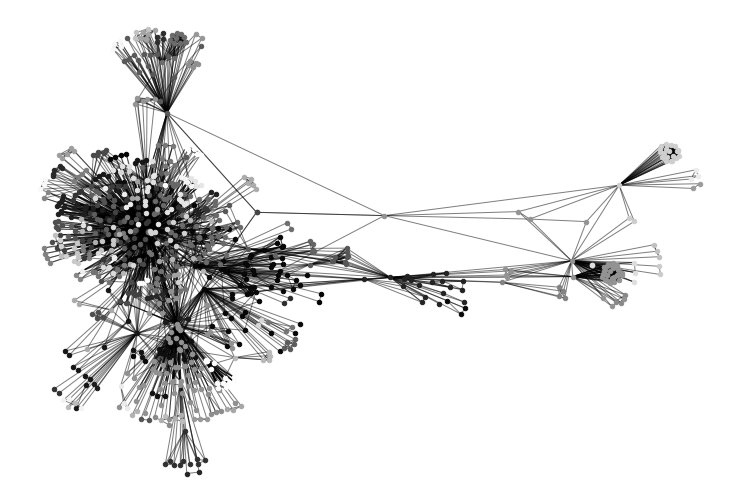

In [25]:
# Desenha o Grafo
plt.figure(figsize=(13, 9))
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0
for com in set(partition.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20, node_color = str(count / size))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.axis('off')
plt.show()

In [26]:
# Mantém apenas comunidades com um mínimo de autores
centers = {}
communities = {}
G_main_com = G.copy()
min_nb = 30
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    if len(list_nodes) < min_nb:
        G_main_com.remove_nodes_from(list_nodes)
    else:
        # Obtém o centro
        H = G_main_com.subgraph(list_nodes)
        d_c = nx.degree_centrality(H)
        center = max(d_c, key=d_c.get)
        centers[center] = com
        communities[com] = center
        # Exibe a comunidade
        print('Comunidade de ', center , '(ID ', com, ') - ', len(list_nodes), ' autores:')
        print(list_nodes, '\n')

Comunidade de  Joao Jose Vasco Peixoto Furtado (ID  3 ) -  61  autores:
['Maria Elizabeth Sucupira Furtado', 'Joao Jose Vasco Peixoto Furtado', 'Rafael Bomfim', 'Rafael Pontes', 'Vladia Celia Monteiro Pinheiro', 'Danielly Barboza Guimaraes', 'Vitor Marques Carvalho', 'Patricia Vasconcelos', 'Gustavo Fernades', 'Leonardo Ayres', 'Tarcisio Pequeno', 'Erneson A Oliveira', 'Hans Hermann', 'Rubens Soares De Oliveira', 'Soares Andrade Jr', 'Hernan A Makse', 'Jose S Andrade', 'Marilia Soares Mendes', 'Patricia Freitas Campos De Vasconcelos', 'Camila Loiola Brito Maia', 'Camila Moura Moreira', 'Daniel Almeida Chagas', 'Anderson Yago Sampaio Brito', 'Andre Soares Lopes', 'Mario W L Moreira', 'Neeraj Kumar', 'Carlos Caminha', 'Jose Dickson Araujo De Oliveira', 'Sarah Mesquita Lima', 'Andre Moreira', 'Eduardo Araujo', "Johnatas D'Orleans", 'Mairon Belchior', 'Marcos De Oliveira', 'Jean Vanderdonckt', 'Carlos Rosemberg', 'Joao Jose Peixoto Furtado', 'Lanna Lima', 'Lanna Sales', 'Matheus Mafra', 'V

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

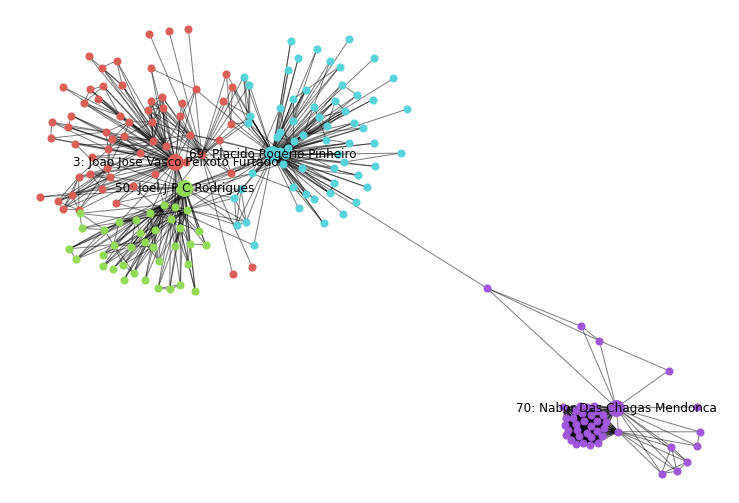

In [27]:
# Exibe o Grafo
plt.figure(figsize=(13, 9))
node_size = 50
count = 0
pos = nx.spring_layout(G_main_com)
colors = dict(zip(communities.keys(), sns.color_palette('hls', len(communities.keys()))))

for com in communities.keys():
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com and nodes not in communities.values()]
    nx.draw_networkx_nodes(G_main_com, pos, list_nodes, node_size = node_size, node_color = colors[com])
    nx.draw_networkx_nodes(G_main_com, pos, list([communities[com]]), node_size = node_size*5, node_color = colors[com])
nx.draw_networkx_edges(G_main_com, pos, alpha=0.5)
labels = {k: str(v) + ': ' + k for k,v in centers.items()}
nx.draw_networkx_labels(G_main_com, pos, labels)
plt.axis('off')
plt.show()

In [28]:
# Exibe o Grafo induzido
nodes_main_com = {k: v for k, v in partition.items() if v in communities}
ind = community.induced_graph(nodes_main_com, G_main_com)
print('Número de Comunidades', len(ind.nodes()))
print('\nComunidades principais e seu nó central:', communities)

Número de Comunidades 4

Comunidades principais e seu nó central: {3: 'Joao Jose Vasco Peixoto Furtado', 50: 'Joel J P C Rodrigues', 69: 'Placido Rogerio Pinheiro', 70: 'Nabor Das Chagas Mendonca'}


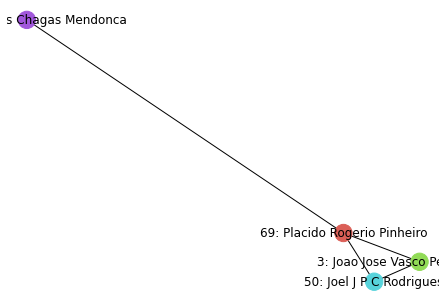

In [29]:
# Exibe o Grafo induzido
colors
pos_ind = nx.spring_layout(ind)
labels = {k: str(k) + ': ' + v for k,v in communities.items()}
nx.draw(ind, pos_ind, node_color=list(colors.values()), labels=labels)
plt.show()

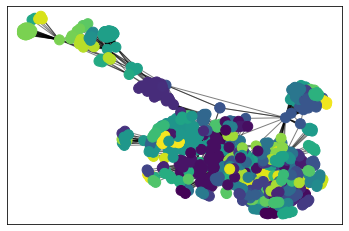

In [30]:
# Retorna partição como dicionário
partition = community_louvain.best_partition(G)
# Visualização
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=100,cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

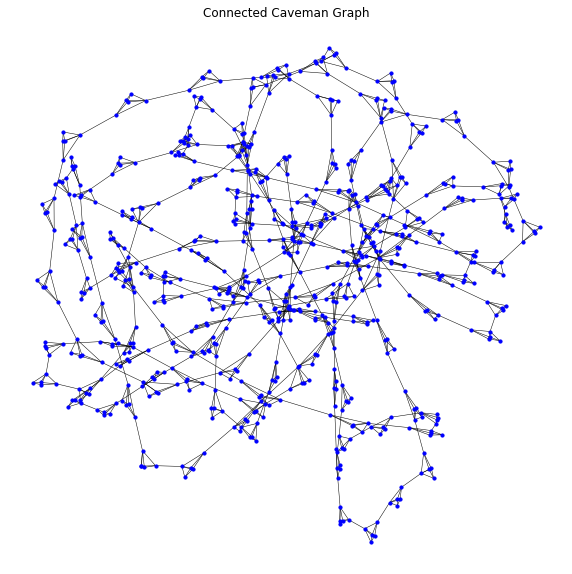

In [33]:
from networkx.generators.community import connected_caveman_graph
G = connected_caveman_graph(150,5)
plt.figure(figsize=(10, 10))
plt.title('Connected Caveman Graph')
# nx.draw(G, pos=nx.spring_layout(G), with_labels=False, font_weight='bold', font_color="w", node_color='b')
nx.draw(G, pos=nx.spring_layout(G), node_size=10, node_color='b', edge_color='k', width=0.5)
